# Project 3: Market Basket Analysis using Apriori Model

## Background Info:

What is apriori?  
Apriori algorithm is frequently used in data mining to find association rules between itemsets.

What is at the core of the apriori algorithm?  
Iteratively building larger/frequent itemsets starting from smaller ones to find association rules between the transactions made.


What are the 2 basic operations of apriori?  
- Joining - Combining frequent itemsets of to generate candidate itemsets of k+1 size.  
- Pruning - Dropping itemsets that have infrequent subsets.

What is the apriori principle?  
When an itemset is frequent, then all of its subsets should also be frequent. For ex: Itemset {apple, orange} is frequent, => {apple} & {orange} must be frequent separately.

How can you overcome overfitting?  
By using pruning methods, cross validation, and using support/confidence thresholds.


What are the benefits and challenges of apriori?  
Benefits: Effective to find association rules in data and useful for small/med datasets.
Challenges: Computationally intensive - require large memory capacity.

## Problem Statement:

I selected the basket dataset because it deals with real-world transactions that captures the daily purchasing habits of customers. This type of dataset is perfect for association rules and its trends because it shows the sequential order of what customers brought, therefore, making it an good choice for applying the Apriori algorithm. Analyzing these shopping patterns, I aim to discover useful trends about customer behavior - such as which products are often bought together. This can help retailers in marketing strategies and product promotions. My overall goal is to explore the relationships between different grocery items and find strong association rules that could improve retailer's business decisions. By using the Apriori model to identify frequent itemsets and rules, I want to highlight the interesting purchasing trends.

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

## Importing & Understanding Data

- The dataset has 11 columns (0-10) representing items purchased by a customer during a transaction.

- Each row is a single transaction, and each cell contains the name of a product or is blank if no product was bought in that "slot."

- All features are categorical — every value is a product name (like whole milk, sausage, pastry)

- Yes, there are missing values. But most people buy just 1–3 things, not 11 things. So, columns 2–10 are empty (null) a lot of the time because those extra "slots" aren't used.

- Unique Values:  
    Column 0: 165 unique items  
    Column 1: 165 unique items  
    Column 2: 154 unique items  
    Columns 8–10: Very few unique items (some columns only have 1 or 2).  

- Common item across columns is "whole milk" as most frequent product listed.

In [127]:
basket = pd.read_csv('basket.csv')

print(basket.head())
print()
print(basket.info())
print()
print(basket.describe())
print()
print("Unique values in each column:")
print(basket.nunique())
print()
print("Missing values:\n", basket.isnull().sum())

             0                   1                    2       3    4    5  \
0   whole milk              pastry          salty snack     NaN  NaN  NaN   
1      sausage          whole milk  semi-finished bread  yogurt  NaN  NaN   
2         soda  pickled vegetables                  NaN     NaN  NaN  NaN   
3  canned beer     misc. beverages                  NaN     NaN  NaN  NaN   
4      sausage    hygiene articles                  NaN     NaN  NaN  NaN   

     6    7    8    9   10  
0  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14963 entries, 0 to 14962
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       14963 non-null  object
 1   1       14963 non-null  object
 2   2       4883 non-null   object
 3   3       2185 non-null   object
 4   4       795 non-null    object
 

## Data Exploration & Visualizations

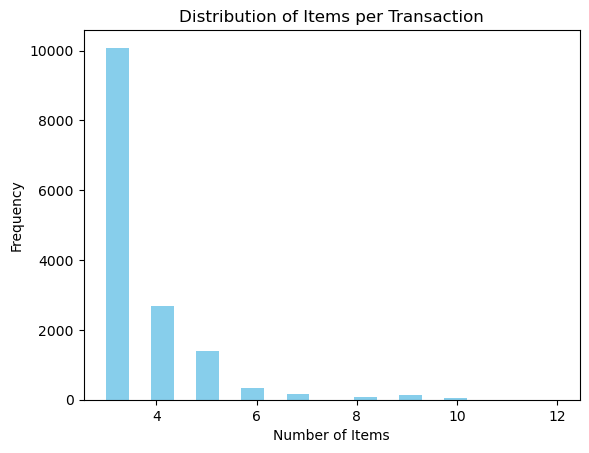

In [137]:
# 1: Number of items per transaction
basket['items_count'] = basket.count(axis=1)
plt.figure()
plt.hist(basket['items_count'], bins=20, color='skyblue')
plt.title('Distribution of Items per Transaction')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.show()

# Most customers buy only a small number of items at once, and larger baskets are rare and may represent 
# special cases like bulk purchases or specific promotions

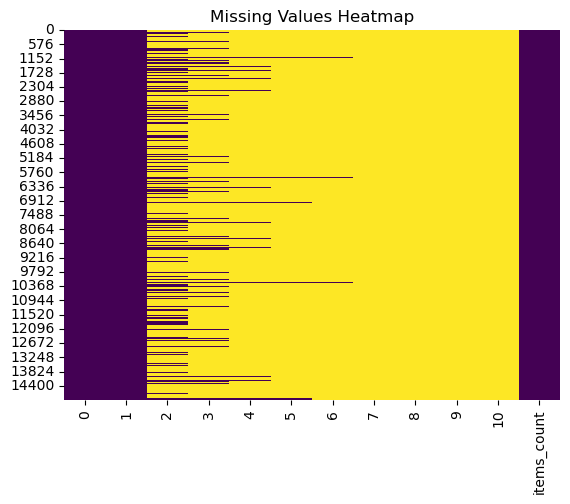

In [151]:
# Plot 2: Heatmap of missing values
plt.figure()
sns.heatmap(basket.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# This allows up to 11 items per transaction, but in real life, most customers buy only just a few things.
# Columns for "extra" items (after the first 2 or 3) are mostly empty because people just aren't shopping so much in one trip.
# Missing values are expected and normal for this kind of shopping data; not an issue of quality.

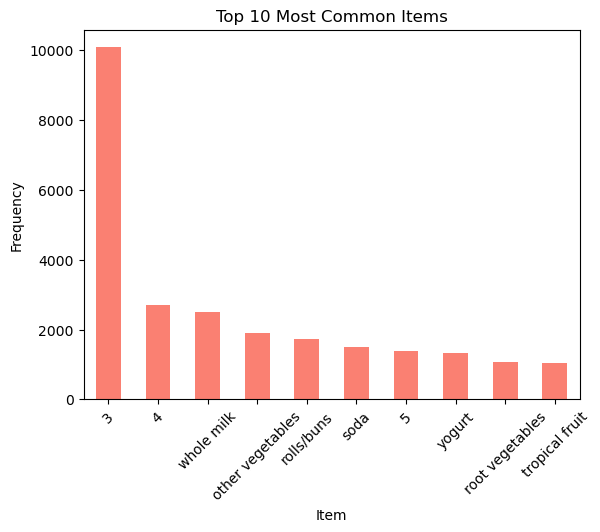

In [143]:
# Plot 3: Count of most common items
# Flatten the basket
flat_items = basket.values.flatten()
flat_items = pd.Series(flat_items)
item_counts = flat_items.value_counts()
item_counts = item_counts.dropna()  # <- Fixed here

plt.figure()
item_counts[:10].plot(kind='bar', color='salmon')
plt.title('Top 10 Most Common Items')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Whole milk is the most popular product.
# Other common items are: other vegetables, rolls/buns, soda, yogurt, root vegetables, tropical fruit

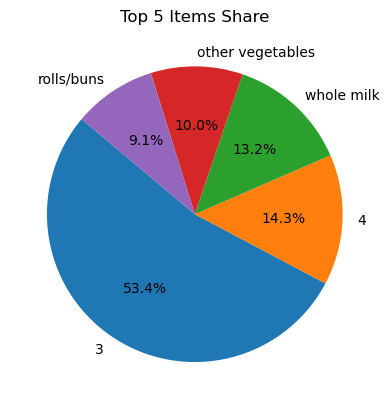

In [153]:
# Plot 4: Pie chart of Top 5 Items
plt.figure()
item_counts[:5].plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Items Share')
plt.ylabel('')
plt.show()

# "Whole milk," "other vegetables," and "rolls/buns" are the major contributors.
# There is a dominant item => data cleaning is needed

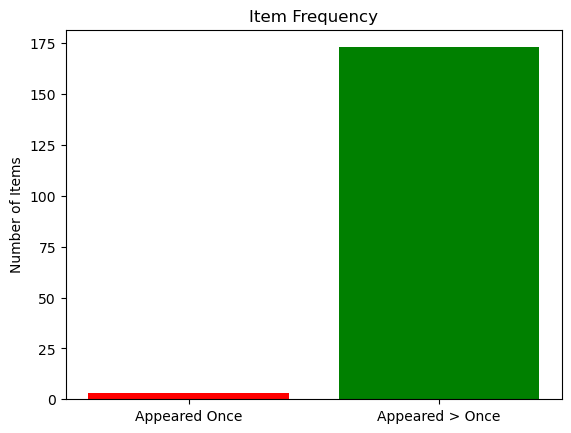

In [155]:
# Plot 5: Items appearing only once vs more
one_time_items = (item_counts[item_counts == 1]).count()
more_than_once_items = (item_counts[item_counts > 1]).count()

plt.figure()
plt.bar(['Appeared Once', 'Appeared > Once'], [one_time_items, more_than_once_items], color=['red', 'green'])
plt.title('Item Frequency')
plt.ylabel('Number of Items')
plt.show()

# The dataset mainly consists of popular items that people redundantly purchase. 
# There are very few outlier items that were purchased only once.

## Scaling & Preprocessing

- Scaling not necessary because apriori uses binary 1/0 - not continuous values.
- Preprocessing measures:
  1. Dropping Missing Values: transactions had empty cols because not every transaction had the same number of items. I dropped these missing values from each transaction so that only actual purchased items were considered.
  2. Type Conversion: items in the dataset were numbers instead of strings, so all items were converted into strings to prevent errors.
  3. One-Hot Encoding: to convert the list of items where each col represents an item and each row represents a transaction

In [165]:
transactions = []
for i in range(basket.shape[0]):
    transaction = basket.iloc[i].dropna().tolist()
    transactions.append(transaction)

# all items to strings
transactions = [[str(item) for item in transaction] for transaction in transactions]

# encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
encoded_basket = pd.DataFrame(te_ary, columns=te.columns_)

print("\nEncoded Basket Preview:")
print(encoded_basket.head())



Encoded Basket Preview:
      10     12      3      4      5      6      7      8      9  \
0  False  False  False   True  False  False  False  False  False   
1  False  False  False  False   True  False  False  False  False   
2  False  False   True  False  False  False  False  False  False   
3  False  False   True  False  False  False  False  False  False   
4  False  False   True  False  False  False  False  False  False   

   Instant food products  ...  turkey  vinegar  waffles  whipped/sour cream  \
0                  False  ...   False    False    False               False   
1                  False  ...   False    False    False               False   
2                  False  ...   False    False    False               False   
3                  False  ...   False    False    False               False   
4                  False  ...   False    False    False               False   

   whisky  white bread  white wine  whole milk  yogurt  zwieback  
0   False        False  

## Building Apriori Model


Frequent Itemsets Found:
     support               itemsets
0   0.673662                    (3)
1   0.180311                    (4)
2   0.092896                    (5)
3   0.022990                    (6)
4   0.021386             (UHT-milk)
..       ...                    ...
59  0.021453  (other vegetables, 4)
60  0.022255        (4, rolls/buns)
61  0.023057              (soda, 4)
62  0.028804        (4, whole milk)
63  0.023859        (5, whole milk)

[64 rows x 2 columns]


Association Rules Found:
    antecedents   consequents   support  confidence      lift
0           (4)  (rolls/buns)  0.022255    0.123425  1.121996
1  (rolls/buns)           (4)  0.022255    0.202309  1.121996
2        (soda)           (4)  0.023057    0.237440  1.316832
3           (4)        (soda)  0.023057    0.127872  1.316832
4           (4)  (whole milk)  0.028804    0.159748  1.011557
5  (whole milk)           (4)  0.028804    0.182395  1.011557
6           (5)  (whole milk)  0.023859    0.256835  1.626

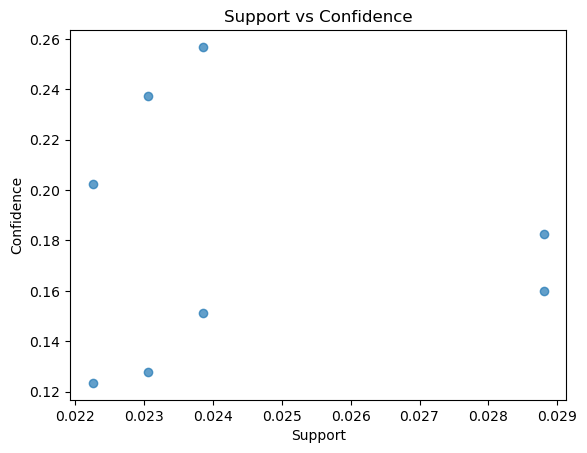

In [176]:
frequent_itemsets = apriori(encoded_basket, min_support=0.02, use_colnames=True)
print("\nFrequent Itemsets Found:")
print(frequent_itemsets)
print()

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print("\nAssociation Rules Found:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
print()

# visualizing rules
plt.figure()
plt.scatter(rules['support'], rules['confidence'], alpha=0.7)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')
plt.show()
